# Model Inference
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hsimonfroy/benchmark-field-level/blob/main/examples/infer_model.ipynb)

Infer from a cosmological model via MCMC samplers.

In [ ]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.75' # NOTE: jax preallocates GPU (default 75%)
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)
print(jdevices())

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload, Path

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname
#!jupyter nbconvert --to script /global/u1/h/hsimfroy/workspace/src/montecosmo/tests/infer_model2.ipynb

save_dir = Path("/feynman/home/dphp/hs276503/scratch/png/lpt_64_fnl_0")
save_path = save_dir / "test"
save_dir.mkdir(parents=True, exist_ok=True)

[CudaDevice(id=0)]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
login33
[NbConvertApp] WARNING | pattern './src/montecosmo/tests/infer_model.ipynb/' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.gen

PermissionError: [Errno 13] Permission denied: '/feynman'

## Experimental setup
### Instantiate model
We can see how the model is actually reparametrized.

###  Generate an observation and condition the model on it
We can see all the free parameters in the model, that we will subsequently sample.

2025-05-19 11:35:28.851299: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# CONFIG
{'a_obs': None,
 'ap_param': False,
 'box_center': array([1365.33215673,  218.00609919,  268.40691564]),
 'box_rotvec': array([0., 0., 0.]),
 'cell_length': 51.2575099840685,
 'curved_sky': True,
 'evolution': 'lpt',
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3111,
                         'low': 0.05,
                         'scale': 0.5,
                         'scale_fid': 0.01},
             'alpha_ap': {'group': 'ap',
                          'high': inf,
                          'label': '{\\alpha}_{\\mathrm{AP}}',
                          'loc': 1.0,
                          'loc_fid': 1.0,
                          'low': 0.0,
                          'scale': 0.1,
                          'scale_fid': 0.01},
             'alpha_iso': {'group': 'ap',
                           'high': inf,
         

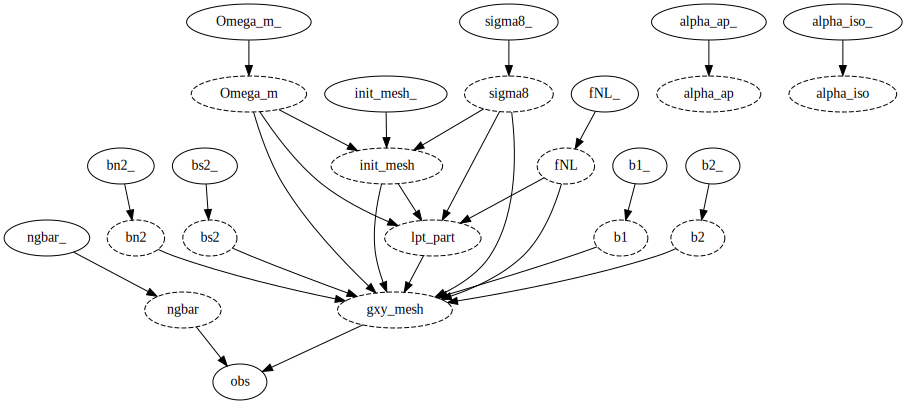

In [2]:
overwrite = False
truth0 = {'Omega_m':0.3, 
    'sigma8':0.8,
    'b1':1.,
    'b2':0., 
    'bs2':0., 
    'bn2': 0.,
    'fNL': 0.,
    'alpha_iso': 1.,
    'alpha_ap': 1.,
    'ngbar':1e-3,}
cell_budget = 64**3
padding = 0.2

if not os.path.exists(save_dir / "truth.npz") or overwrite:

    model = FieldLevelModel(**default_config | 
                                {'mesh_shape': 3*(64,), 
                                'cell_length': 10., 
                                'box_center': (0.,0.,2000.), # in Mpc/h
                                'box_rotvec': (0.,0.,0.), # rotation vector in radians
                                'evolution': 'lpt',
                                'a_obs': None, # light-cone if None
                                'curved_sky': True, # curved vs. flat sky
                                'ap_param': False, # parametrized AP vs. auto AP
                                'window': padding, # if float, padded fraction, if str or Path, path to window mesh file
                                } )
    
    fits_path = Path("/home/nfs/bao/AbacusSummit_v4_2/mock0/LRG_complete_SGC_1_clustering.ran.fits")
    model.add_window(fits_path, cell_budget, padding, save_dir / "window.npy")

    print(model)
    truth = model.predict(samples=truth0, hide_base=False, hide_samp=False, hide_det=False, from_base=True)
    model.save(save_dir / "model.yaml")    
    jnp.savez(save_dir / "truth.npz", **truth)

    model2 = FieldLevelModel(**model.asdict() | {'evolution': 'kaiser', 'curved_sky':False, 'window':None})
    # print(model2)
    truth2 = model2.predict(samples=truth0, hide_base=False, hide_samp=False, from_base=True)
    model2.save(save_dir / "model2.yaml")    
    jnp.savez(save_dir / "truth2.npz", **truth2)
else:
    model = FieldLevelModel.load(save_dir / "model.yaml")
    print(model)
    truth = np.load(save_dir / "truth.npz")

    model2 = FieldLevelModel.load(save_dir / "model2.yaml")
    # print(model2)
    truth2 = np.load(save_dir / "truth2.npz")

model.render()
# model2.render("bnet.png")

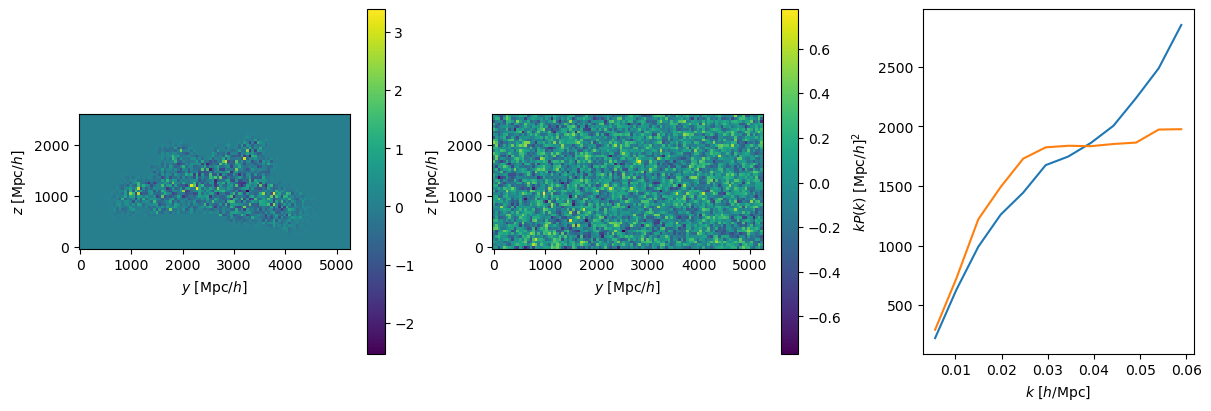

In [4]:
from montecosmo.plot import plot_mesh, plot_pow

axis = 0
ind = .1
delta_obs  = model.count2delta(truth['obs'])
delta_obs2 = model2.count2delta(truth2['obs'])

plt.figure(figsize=(12, 4), layout='constrained')
plt.subplot(131)
plot_mesh(delta_obs, model.box_shape, ind, axis)
plt.colorbar()

plt.subplot(132)
plot_mesh(delta_obs2, model.box_shape, ind, axis)
plt.colorbar()

plt.subplot(133)
kpow = model.spectrum(delta_obs)
kpow2 = model2.spectrum(delta_obs2)
plot_pow(*kpow);
plot_pow(*kpow2);

## Perform the inference

### Warmup the field only

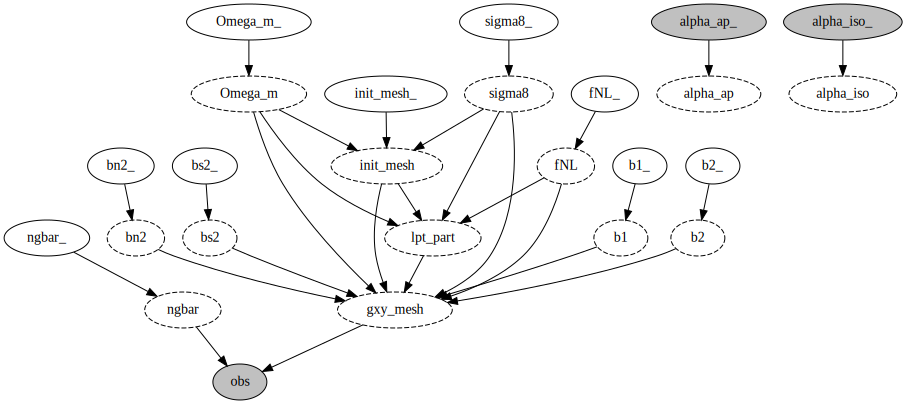

In [5]:
n_samples, n_runs, n_chains = 128, 64, 4
tune_mass = True
# overwrite = True
overwrite = False

params_init = jit(vmap(partial(model.kaiser_post, delta_obs=delta_obs, scale_field=1/10)))(jr.split(jr.key(45), n_chains))    
params_init2 = jit(vmap(partial(model2.kaiser_post, delta_obs=delta_obs2)))(jr.split(jr.key(45), n_chains))

if not os.path.exists(save_path+"_warm_state.p") or overwrite:
    print("Warming up...")
    model.reset()
    model.condition({'obs': truth['obs']} | model.loc_fid, from_base=True)
    model.block()

    from montecosmo.samplers import get_mclmc_warmup
    warmup_fn = jit(vmap(get_mclmc_warmup(model.logpdf, n_steps=2**13, config=None, 
                                desired_energy_var=1e-6, diagonal_preconditioning=False)))
    state, config = warmup_fn(jr.split(jr.key(43), n_chains), {k: params_init[k] for k in ['init_mesh_']})
    pdump(state, save_path+"_warm_state.p")
    pdump(config, save_path+"_warm_conf.p")
else:
    state = pload(save_path+"_warm_state.p")
    config = pload(save_path+"_warm_conf.p")

# obs = ['obs','b1','b2','bs2','bn2','fNL','ngbar','alpha_iso','alpha_ap']
# obs = ['obs','Omega_m','sigma8','b1','b2','bs2','bn2','ngbar']
# obs = ['obs','b1','b2','bs2','bn2','fNL','ngbar']
# obs = ['obs','b2','bs2','bn2','fNL','ngbar','alpha_iso','alpha_ap']
# obs = ['obs','fNL','ngbar','alpha_iso','alpha_ap']
# obs = ['obs','ngbar','alpha_iso','alpha_ap']
obs = ['obs','alpha_iso','alpha_ap']
# obs = ['obs', 'ngbar']
obs = {k: truth[k] for k in obs}

model.reset()
model.condition(obs, from_base=True)
model.render()
model.block()

params_warm = params_init | state.position
params_warm = {k: params_warm[k] for k in params_warm.keys() - model.data.keys()}

In [6]:
from montecosmo.plot import plot_pow, plot_trans, plot_coh, plot_powtranscoh
from montecosmo.bricks import lin_power_interp

mesh_true = jnp.fft.irfftn(truth['init_mesh'])
kpow_true = model.spectrum(mesh_true)
kpow_fid = kpow_true[0], lin_power_interp(model.cosmo_fid)(kpow_true[0])
kptc_obs = model.powtranscoh(mesh_true, delta_obs)
kptcs_init = vmap(lambda x: model.powtranscoh(mesh_true, model.reparam(x, fourier=False)['init_mesh']))(params_init)
kptcs_init2 = vmap(lambda x: model2.powtranscoh(mesh_true, model2.reparam(x, fourier=False)['init_mesh']))(params_init2)
kptcs_warm = vmap(lambda x: model.powtranscoh(mesh_true, model.reparam(x, fourier=False)['init_mesh']))(params_warm)

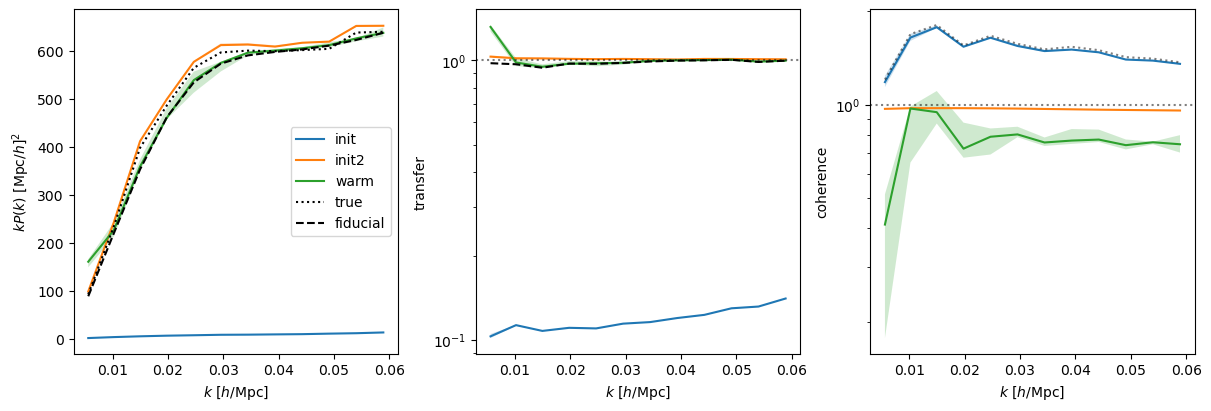

In [7]:
prob = 0.95

plt.figure(figsize=(12, 4), layout='constrained')
def plot_kptcs(kptcs, label=None):
    plot_powtranscoh(*kptcs, fill=prob)
    plot_powtranscoh(*tree.map(lambda x: jnp.median(x, 0), kptcs), label=label)

plot_kptcs(kptcs_init, label='init')
plot_kptcs(kptcs_init2, label='init2')
plot_kptcs(kptcs_warm, label='warm')

plt.subplot(131)
plot_pow(*kpow_true, 'k:', label='true')
plot_pow(*kpow_fid, 'k--', label='fiducial')
plt.legend()
plt.subplot(132)
plot_trans(kpow_true[0], (kpow_fid[1] / kpow_true[1])**.5, 'k--', label='fiducial')
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plot_coh(kptc_obs[0], kptc_obs[3], 'k:', alpha=0.5, label='obs');
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.savefig(save_path+f'_init_warm.png')   

### Warmup all parameters and run

In [ ]:
# jconfig.update("jax_debug_nans", True)
from tqdm import tqdm
from montecosmo.samplers import get_mclmc_warmup, get_mclmc_run
from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState
# overwrite = True
overwrite = False

n_samples, n_runs, n_chains = 128, 64, 4

if not os.path.exists(save_path+"_warm_state.p") or overwrite:
    print("Warming up...")
    warmup_fn = jit(vmap(get_mclmc_warmup(model.logpdf, n_steps=2**14, config=None, # 2**13
                                        desired_energy_var=3e-7, diagonal_preconditioning=tune_mass)))
    state, config = warmup_fn(jr.split(jr.key(43), n_chains), params_warm)

    eval_per_ess = 1e3
    ss = jnp.median(config.step_size)
    config = MCLMCAdaptationState(L=0.4 * eval_per_ess/2 * ss, 
                                step_size=ss, 
                                inverse_mass_matrix=jnp.median(config.inverse_mass_matrix, 0))
    config = tree.map(lambda x: jnp.broadcast_to(x, (n_chains, *jnp.shape(x))), config)
    
    print("ss: ", config.step_size)
    print("L: ", config.L)
    from jax.flatten_util import ravel_pytree
    flat, unrav_fn = ravel_pytree(tree.map(lambda x:x[0], state.position))
    print("inv_mm:", unrav_fn(config.inverse_mass_matrix[0]))
    print(tree.map(vmap(lambda x: jnp.isnan(x).sum()), state.position))

    pdump(state, save_path+"_warm2_state.p")
    pdump(config, save_path+"_conf.p")

else:
    state = pload(save_path+"_warm2_state.p")
    config = pload(save_path+"_conf.p")

state = pload(save_path+"_last_state.p")
run_fn = jit(vmap(get_mclmc_run(model.logpdf, n_samples, thinning=64, progress_bar=False)))

key = jr.key(42)
start = 3 #####
end = start + n_runs - 1
for i_run in tqdm(range(start, end + 1)):
    print(f"run {i_run}/{end}")
    key, run_key = jr.split(key, 2)
    state, samples = run_fn(jr.split(run_key, n_chains), state, config)
    
    print("MSE per dim:", jnp.mean(samples['mse_per_dim'], 1), '\n')
    jnp.savez(save_path+f"_{i_run}.npz", **samples)
    pdump(state, save_path+"_last_state.p")


  0%|          | 0/64 [00:00<?, ?it/s]

run 3/66
MSE per dim: [2.74246373e-07 2.51672243e-07 2.10590991e-07 1.81658892e-07] 



  2%|▏         | 1/64 [29:41<31:10:38, 1781.57s/it]

run 4/66
MSE per dim: [2.04325397e-07 1.82318867e-07 1.81068137e-07 1.79121669e-07] 



  3%|▎         | 2/64 [55:52<28:32:57, 1657.70s/it]

run 5/66
MSE per dim: [2.04520092e-07 1.76841745e-07 2.24895973e-07 1.76537320e-07] 



  5%|▍         | 3/64 [1:25:46<29:08:39, 1719.99s/it]

run 6/66
MSE per dim: [1.91908342e-07 1.99000977e-07 1.57092129e-07 2.49112951e-07] 



  6%|▋         | 4/64 [2:11:06<35:14:38, 2114.65s/it]

run 7/66
MSE per dim: [2.68406468e-07 2.60718080e-07 1.98039572e-07 1.91677944e-07] 



  8%|▊         | 5/64 [2:54:07<37:24:40, 2282.72s/it]

run 8/66
MSE per dim: [2.32146269e-07 1.82885414e-07 1.91892789e-07 2.13466550e-07] 



  9%|▉         | 6/64 [3:27:26<35:13:36, 2186.49s/it]

run 9/66
MSE per dim: [2.05851890e-07 1.92704531e-07 2.15282066e-07 1.70228121e-07] 



 11%|█         | 7/64 [3:53:29<31:23:34, 1982.72s/it]

run 10/66
MSE per dim: [1.67119755e-07 1.82960334e-07 1.78661904e-07 2.34949453e-07] 



 12%|█▎        | 8/64 [4:19:33<28:45:53, 1849.17s/it]

run 11/66


In [1]:
!kill 3165465

/bin/bash: line 0: kill: (3165465) - No such process


In [1]:
config = pload(save_path+"_conf.p")
state = pload(save_path+"_last_state.p")

print("ss: ", config.step_size)
print("L: ", config.L)
from jax.flatten_util import ravel_pytree
flat, unrav_fn = ravel_pytree(tree.map(lambda x:x[0], state.position))
print("inv_mm:", unrav_fn(config.inverse_mass_matrix[0]))

NameError: name 'pload' is not defined

In [11]:
from montecosmo.plot import plot_pow, plot_trans, plot_coh, plot_powtranscoh
from montecosmo.bricks import lin_power_interp
mesh_true = jnp.fft.irfftn(truth['init_mesh'])
kpow_true = model.spectrum(mesh_true)
kpow_fid = kpow_true[0], lin_power_interp(model.cosmo_fid)(kpow_true[0])
kptc_obs = model.powtranscoh(mesh_true, delta_obs)
kptcs_init = vmap(lambda x: model.powtranscoh(mesh_true, model.reparam(x, fourier=False)['init_mesh']))(params_init)
kptcs_warm = vmap(lambda x: model.powtranscoh(mesh_true, model.reparam(x, fourier=False)['init_mesh']))(params_warm)
kptcs_run = vmap(lambda x: model.powtranscoh(mesh_true, model.reparam(x, fourier=False)['init_mesh']))(state.position)

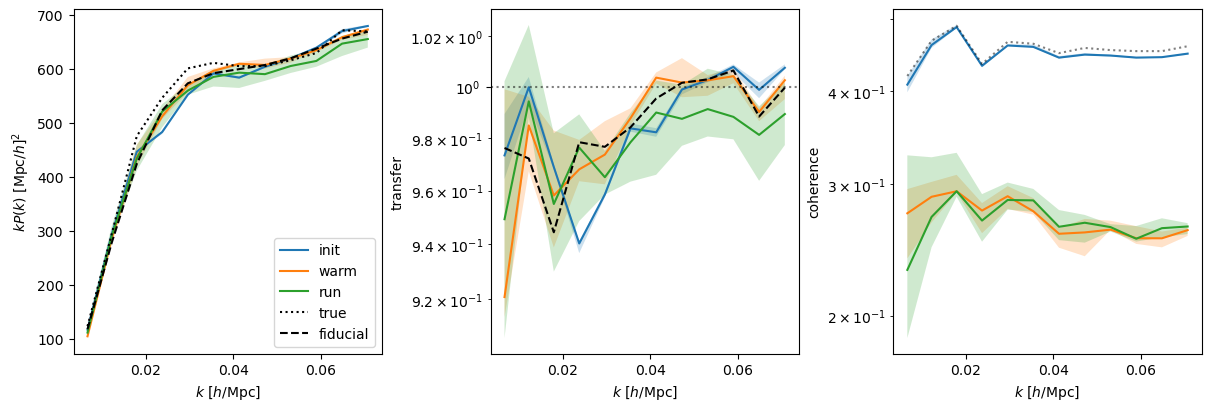

In [12]:
prob = 0.95
plt.figure(figsize=(12, 4), layout='constrained')
def plot_kptcs(kptcs, label=None):
    plot_powtranscoh(*kptcs, fill=prob)
    plot_powtranscoh(*tree.map(lambda x: jnp.median(x, 0), kptcs), label=label)

plot_kptcs(kptcs_init, label='init')
plot_kptcs(kptcs_warm, label='warm')
plot_kptcs(kptcs_run, label='run')

plt.subplot(131)
plot_pow(*kpow_true, 'k:', label='true')
plot_pow(*kpow_fid, 'k--', label='fiducial')
plt.legend()
plt.subplot(132)
plot_trans(kpow_true[0], (kpow_fid[1] / kpow_true[1])**.5, 'k--', label='fiducial')
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plot_coh(kptc_obs[0], kptc_obs[3], 'k:', alpha=0.5, label='obs');
# plt.axhline(1., linestyle=':', color='k', alpha=0.5)
# plt.savefig(f'init_warm.png')   

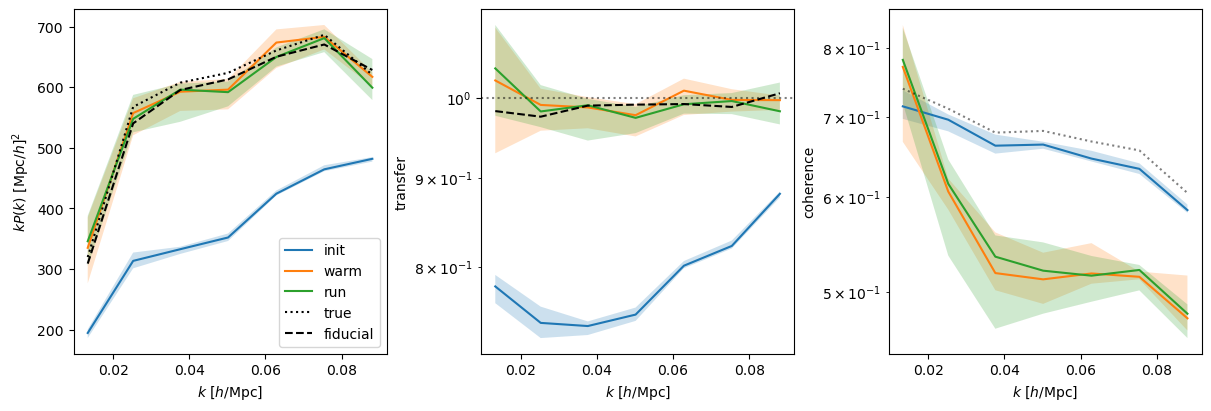

In [ ]:
prob = 0.95
plt.figure(figsize=(12, 4), layout='constrained')
tree_med = lambda y: tree.map(lambda x: jnp.median(x, 0), y)
plot_powtranscoh(*tree_med(kptcs_init), label='init')
plot_powtranscoh(*kptcs_init, fill=prob)
plot_powtranscoh(*tree_med(kptcs_warm), label='warm')
plot_powtranscoh(*kptcs_warm, fill=prob)
plot_powtranscoh(*tree_med(kptcs_run), label='run')
plot_powtranscoh(*kptcs_run, fill=prob)
plt.subplot(131)
plot_pow(*kpow_true, 'k:', label='true')
plot_pow(*kpow_fid, 'k--', label='fiducial')
plt.legend()
plt.subplot(132)
plot_trans(kpow_true[0], (kpow_fid[1] / kpow_true[1])**.5, 'k--', label='fiducial')
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plot_coh(kptc_obs[0], kptc_obs[3], 'k:', alpha=0.5, label='obs');
# plt.axhline(1., linestyle=':', color='k', alpha=0.5)
# plt.savefig(f'init_glin_{task_id}.png')   